# Graphical Verification of Passes
#### Ethan Dickey, Quantum Research Intern (Master's): Summer 2021
#### POC: Chris Wood

This notebook adds further verification of the `CrossTalkDelyError` and `DelayError` noise passes via graphical analysis.

Please review "./Delay Relation and Cross Talk Errors.ipynb" for an introduction to these passes as this notebook jumps right in.

## TOC
- Verification of `CrossTalkDelayError` pass via graphical oscillations of probability
  - Why oscillations of probability?
  - Useful functions
  - Expected results
  - `CrossTalkDelayError` results
- Verification of both `CrossTalkDelayError` and `DelayError` passes via graphical dampened oscillations of probability

## Verification of CrossTalkDelayError pass via graphical oscillations of probability

### Why oscillations of probability?

idek
todo##################################################################

### Useful functions
The following 4 functions allow construction of a H-Delay-H circuit with and without crosstalk noise manually added (via RZZ gates).  They also allow for the retrieval of the statevectors for probability counts without measurement.

The figure shows what the test circuit structure is WITH noise manually added.

In [16]:
#python
import numpy as np
#qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock import FakeVigo
from qiskit.transpiler import PassManager
import qiskit.quantum_info as qi
#custom passes
from delayPasses.crossTalkPass import CrossTalkDelayReplace
from delayPasses.delayRelaxationPass import DelayReplace

###TODO:: clean up and make this file more consistent (same parameters for final functions called)#####

def test_circuit(coupling_map, theta=0, add_noise=False, delay=10):
    nq = np.max(coupling_map) + 1
    qc = QuantumCircuit(nq)
    qc.h(range(nq))
    qc.barrier(range(nq))
    qc.delay(delay, range(nq))
    if add_noise and coupling_map:
        finished = [] #coupling map has i, j and j, i
        for i, j in coupling_map:
            if [i, j] not in finished:
                qc.rzz(theta, i, j)
                finished.append([i, j])
                finished.append([j, i])
    qc.barrier(range(nq))
    qc.h(range(nq))
    return qc

def test_state(coupling_map, theta=0, add_noise=False):
    qc = test_circuit(coupling_map, theta, add_noise)
    return qi.Statevector.from_int(0, 2 ** qc.num_qubits).evolve(qc)

def test_crosstalk_circuit(backend, theta=0.1):
    coupling_map = backend.configuration().coupling_map
    
    qc = test_circuit(coupling_map=coupling_map, delay=1000)
    qc = transpile(qc, backend, scheduling_method='alap')
    
    pm = PassManager()
    pm.append([CrossTalkDelayReplace(coupling_map, theta)])

    qc = pm.run(qc)
    return qc

def test_crosstalk_state(backend, theta=0.1):
    qc = test_crosstalk_circuit(backend, theta)
    return qi.Statevector.from_int(0, 2 ** qc.num_qubits).evolve(qc)

test_circuit(coupling_map=FakeVigo().configuration().coupling_map, theta=0.1, add_noise=True).draw(fold=-1)

┌───┐ ░ ┌───────────────┐                                         ░ ┌───┐
q_0: ┤ H ├─░─┤ DELAY(10[dt]) ├─■───────────────────────────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤ │ZZ(0.1)                                ░ ├───┤
q_1: ┤ H ├─░─┤ DELAY(10[dt]) ├─■─────────■─────────■───────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤           │ZZ(0.1)  │                   ░ ├───┤
q_2: ┤ H ├─░─┤ DELAY(10[dt]) ├───────────■─────────┼───────────────────░─┤ H ├
     ├───┤ ░ ├───────────────┤                     │ZZ(0.1)            ░ ├───┤
q_3: ┤ H ├─░─┤ DELAY(10[dt]) ├─────────────────────■─────────■─────────░─┤ H ├
     ├───┤ ░ ├───────────────┤                               │ZZ(0.1)  ░ ├───┤
q_4: ┤ H ├─░─┤ DELAY(10[dt]) ├───────────────────────────────■─────────░─┤ H ├
     └───┘ ░ └───────────────┘                                         ░ └───┘

### Expected results

This graph demonstrates the expected results by manually adding crosstalk noise (via RZZ gates) into the circuit.

In [6]:
#set up theta for all tests
theta_range = np.linspace(0, 2 * np.pi, 50)

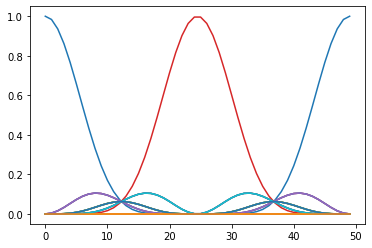

In [12]:
import matplotlib.pyplot as plt
from qiskit.test.mock import FakeVigo

backend = FakeVigo()
coupling_map = backend.configuration().coupling_map
states_expected = [test_state(coupling_map, theta=theta, add_noise=True) for theta in theta_range]
probs = np.array([psi.probabilities() for psi in states_expected]).T
for p in probs:
    plt.plot(p)

### `CrossTalkDelayError` Results

This graph verifies the `CrossTalkDelayError` pass by producing the same results as expected above.

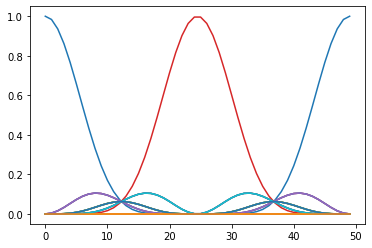

In [17]:
states_crosstalk = [test_crosstalk_state(backend, theta=theta) for theta in theta_range]
probs_crosstalk = np.array([psi.probabilities() for psi in states_crosstalk]).T
for p in probs_crosstalk:
    plt.plot(p)